# EDA для задачи предсказания результатов экзаменов учеников

Основные цели и задачи проекта: отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска. Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [2]:
#  Присваиваем название загруженого датасета
stud = pd.read_csv('stud_math.csv')

In [3]:
#  Функции используемые для анализа

def first_look(col, boundaries=None):
    print('Столбец', col)
    print('Распределение признака:')
    fig, ax = plt.subplots()
    # Проверка на строковый тип данных
    if stud.loc[:, col].dtypes == np.dtype('O'):
        sns.countplot(stud.loc[:, col], ax=ax)
        plt.show()
    else:

        stud.loc[:, col].hist(ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel('count')
        plt.show()
        if boundaries is not None:  # Проверка на наличие выбросов по информации из датасета
            if stud.loc[(~stud.loc[:, col].between(boundaries[0], boundaries[1])) &
                        pd.notnull(stud.loc[:, col])].shape[0] > 0:
                print('Найдены выбросы:')
                display(stud.loc[(~stud.loc[:, col]).between(boundaries[0], boundaries[1]) &
                                 pd.notnull(stud.loc[:, col])])
        print('Процент пропусков:', str(
            round(100 - stud.loc[:, col].count()/stud.shape[0]*100, 2)) + '%')
        print()


# Функция для постройки Boxplot графиков
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=stud,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


# Функция, которую можно применить к столбцам с большим количеством пропусков для замены на моду:
# def fill_na(col):
#     mode = col.mode()[0]
#     col = col.fillna(mode)


# Функция, которую можно применить к выбросам для изменение значения к крайнему усов Boxplot:
# def vibros():
#     for column in df.columns:
#         if column in num_columns:
#             q1 = df[column].quantile(q = 0.25)
#             q3 = df[column].quantile(q = 0.75)
#             for value in df[column]:
#                 if value - 2*(df[column].std()) >= q3:
#                     value = q3
#                     elif value + 2*(df[column].std()) <= q1:
#                         value = q1

# 1.Первичная обработка данных

In [4]:
# Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов:
display(stud.head(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Датасет с данными об учениках состоит из 395 строк и 30 столбцов, 13 из которых закодированы числами и 17 - строковые.
Столбец 'studytime, granular' который не описан в задании и мы не знаем что это за величина.

# 2. Анализ данных в столбцах

In [5]:
# Удаляем 'studytime, granular' по причине описанный выше.
stud = stud.drop('studytime, granular', 1)

Столбец school
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


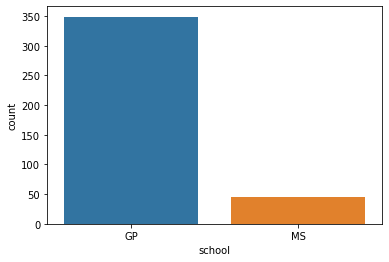

In [6]:
# Рассмотрим столбцы 'school' и 'sex'.
first_look('school')

Столбец sex
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


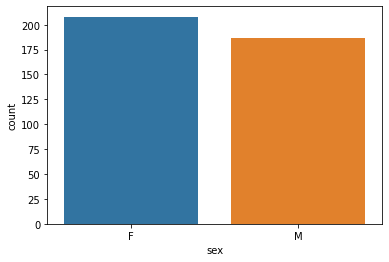

In [7]:
first_look('sex')

Оба столбца 'school' и 'sex' являются бинарными строковыми величинами без выбросов

Столбец age
Распределение признака:


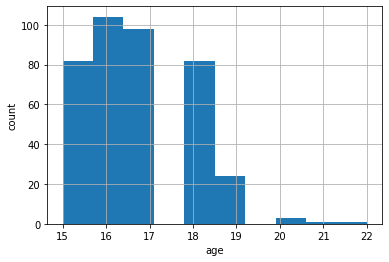

Процент пропусков: 0.0%



In [8]:
# Cтолбец 'age' числовой и без пропусков. Поэтому посмотрим на его распределение:
first_look('age')

Cтолбец 'age' содержит числовые величины без выбросов (условие от 15 до 22)

Столбец address
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


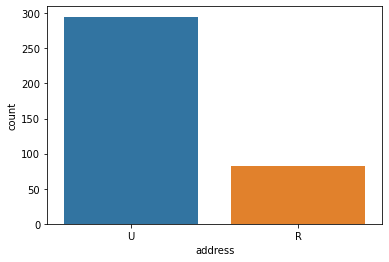

In [9]:
# Рассмотрим столбец 'address'
first_look('address')

Cтолбец 'address' содержит бинарные строковые величины без выбросов, означающие городских и загородных учеников ('U' - городской, 'R' - за городом)

Столбец famsize
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


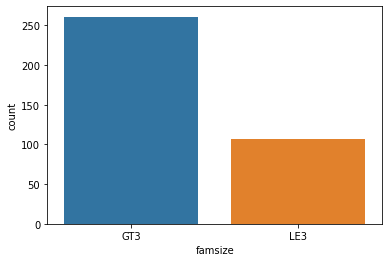

In [10]:
# Расмотрим столбец 'famsize'
first_look('famsize')

Cтолбец 'famsize' содержит бинарные строковые величины без выбросов, означающие размер семьи('LE3' <= 3, 'GT3' >3)

Столбец Pstatus
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


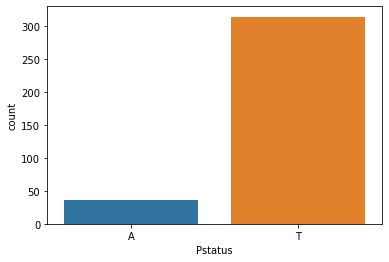

In [11]:
# Расмотрим столбец 'Pstatus'
first_look('Pstatus')

Cтолбец 'Pstatus' содержит бинарные строковые величины без выбросов, означающие статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

Столбец Medu
Распределение признака:


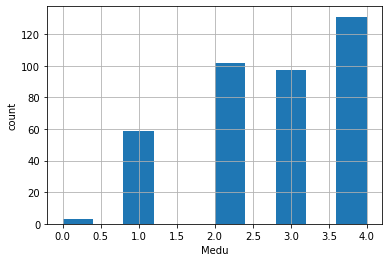

Процент пропусков: 0.76%



In [12]:
# Расмотрим столбец 'Medu'
first_look('Medu')

Столбец Fedu
Распределение признака:


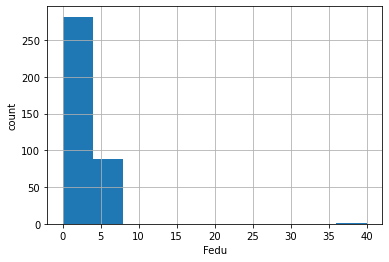

Процент пропусков: 6.08%



In [13]:
# Расмотрим столбец 'Fedu'
first_look('Fedu')

Столбец 'Fedu' содержит выброс который нужно заменить на моду. По условиям задачи образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее). И потом ВЫЗМОЖНО обьеденим 'Medu' и 'Fedu'

In [14]:
# Устраняем выброс который больше 4х баллов (по условию)
stud['Fedu'] = np.where(stud['Fedu'] > 4, stud.Fedu.mode(), stud['Fedu'])

Столбец Mjob
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


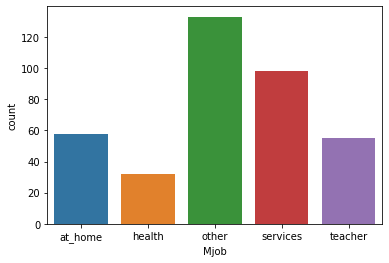

In [15]:
# Расмотрим столбец 'Mjob'
first_look('Mjob')

Столбец Fjob
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


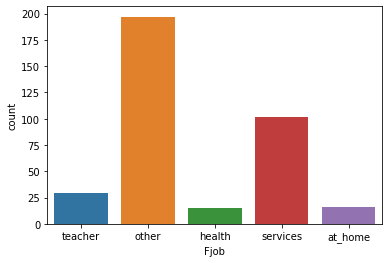

In [16]:
# Расмотрим столбец 'Fjob'
first_look('Fjob')

Столбец reason
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


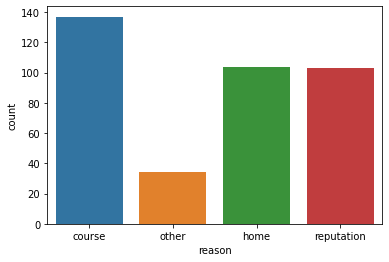

In [17]:
# Расмотрим столбец 'reason'
first_look('reason')

Столбец guardian
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


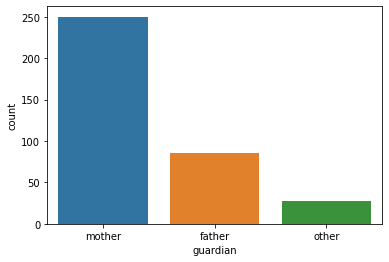

In [18]:
# Расмотрим столбец 'guardian'
first_look('guardian')

Столбец traveltime
Распределение признака:


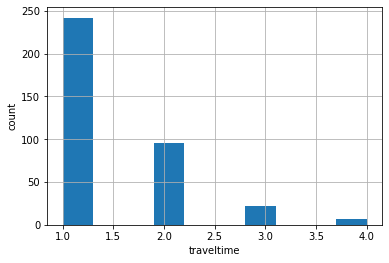

Процент пропусков: 7.09%



In [19]:
# Расмотрим столбец 'traveltime'
first_look('traveltime')

Столбец 'traveltime' содержит цисловые величины. Означает время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

Столбец studytime
Распределение признака:


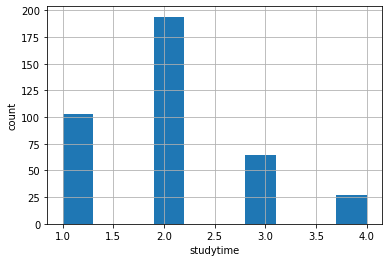

Процент пропусков: 1.77%



In [20]:
# Расмотрим столбец 'studytime'
first_look('studytime')

Столбец 'studytime' содержит цисловые величины. Означает время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

Столбец failures
Распределение признака:


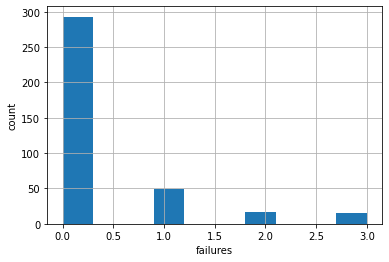

Процент пропусков: 5.57%



In [21]:
# Расмотрим столбец 'failures'
first_look('failures')

Исходя из условия, значение "0" скорее всего считатается как ученик, который впервые сдает экзамен (по условию, количество внеучебных неудач (n, если 1<=n<=3, иначе 0))

Столбец schoolsup
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


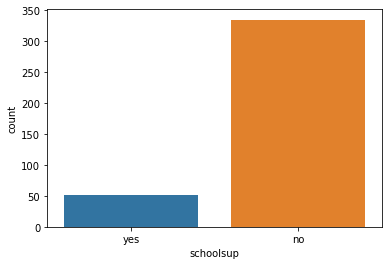

In [22]:
# Расмотрим столбец 'schoolsup'
first_look('schoolsup')

Cтолбец 'schoolsup' содержит бинарные строковые величины без выбросов. Означает дополнительная образовательная поддержка (yes или no)

Столбец famsup
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


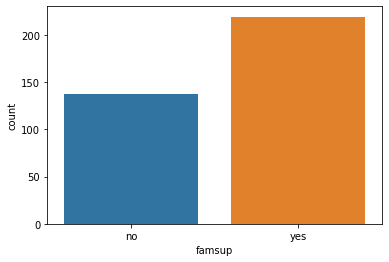

In [23]:
# Расмотрим столбец 'famsup'
first_look('famsup')

Cтолбец 'famsup' содержит бинарные строковые величины без выбросов. Означает семейная образовательная поддержка (yes или no)

Столбец paid
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


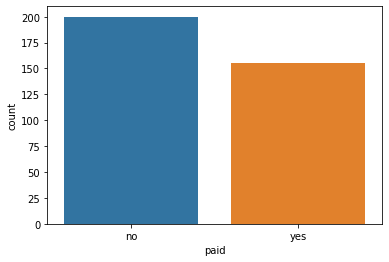

In [24]:
# Расмотрим столбец 'paid'
first_look('paid')

Cтолбец 'paid' содержит бинарные строковые величины без выбросов. Означает дополнительные платные занятия по математике (yes или no)

Столбец activities
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


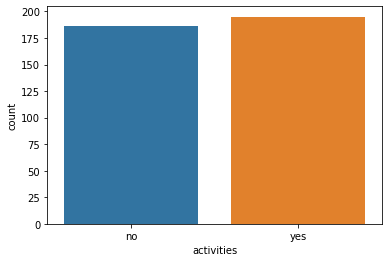

In [25]:
# Расмотрим столбец 'activities'
first_look('activities')

Cтолбец 'activities' содержит бинарные строковые величины без выбросов. Означает дополнительные внеучебные занятия (yes или no)

Столбец nursery
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


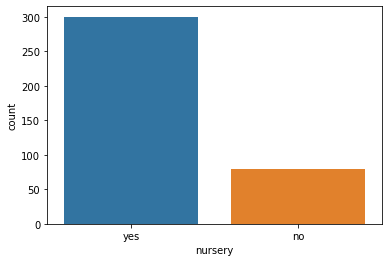

In [26]:
# Расмотрим столбец 'nursery'
first_look('nursery')

Cтолбец 'nursery' содержит бинарные строковые величины без выбросов. Означает посещал ли детский сад (yes или no)

Столбец higher
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


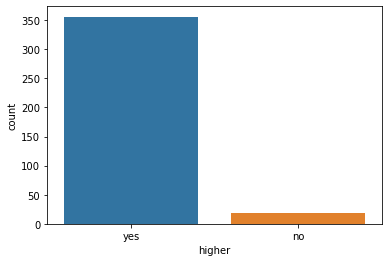

In [27]:
# Расмотрим столбец 'higher'
first_look('higher')

Cтолбец 'higher' содержит бинарные строковые величины без выбросов. Означает хочет ли получить высшее образование (yes или no)

Столбец internet
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


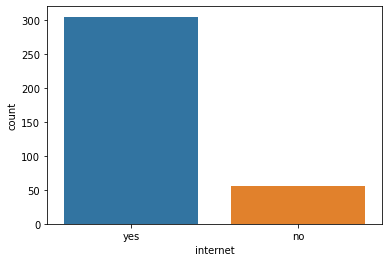

In [28]:
# Расмотрим столбец 'internet'
first_look('internet')

Cтолбец 'internet' содержит бинарные строковые величины без выбросов. Означает наличие интернета дома (yes или no)

Столбец romantic
Распределение признака:


C:\Users\Makc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


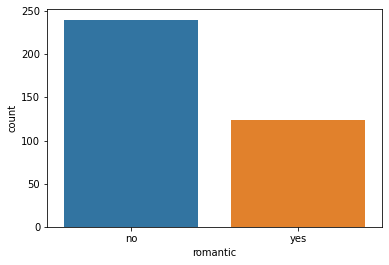

In [29]:
# Расмотрим столбец 'romantic'
first_look('romantic')

Cтолбец 'romantic' содержит бинарные строковые величины без выбросов. Означает наличие романтических отношений (yes или no)

Столбец famrel
Распределение признака:


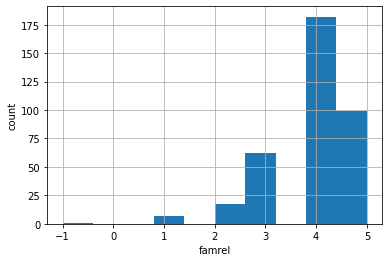

Процент пропусков: 6.84%



In [30]:
# Расмотрим столбец 'famrel'
first_look('famrel')

Столбец 'famrel' содержит цисловые величины. По условиям это семейные отношения (от 1 - очень плохо до 5 - очень хорошо). Найден вброс '-1', который нужно заменить на моду.

In [31]:
stud.famrel = np.where(stud.famrel == -1, stud.famrel.mode(), stud.famrel)

Столбец freetime
Распределение признака:


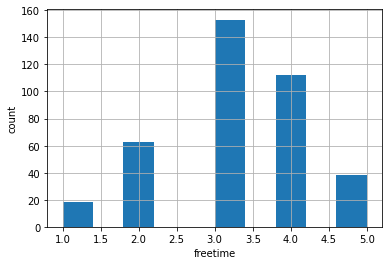

Процент пропусков: 2.78%



In [32]:
# Расмотрим столбец 'freetime'
first_look('freetime')

Столбец 'freetime' содержит числовые величины. Означает свободное время после школы (от 1 - очень мало до 5 - очень мого)

Столбец goout
Распределение признака:


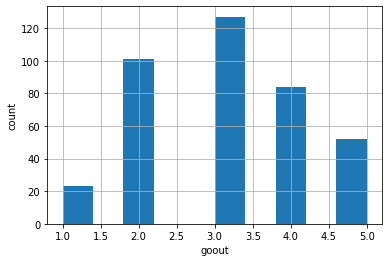

Процент пропусков: 2.03%



In [33]:
# Расмотрим столбец 'goout'
first_look('goout')

Столбец 'goout' содержит числовые величины. Означает проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

Столбец health
Распределение признака:


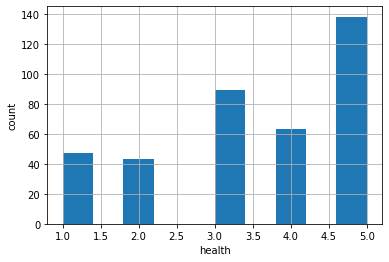

Процент пропусков: 3.8%



In [34]:
# Расмотрим столбец 'health'
first_look('health')

Столбец 'health' содержит числовые величины. Означает текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

Столбец absences
Распределение признака:


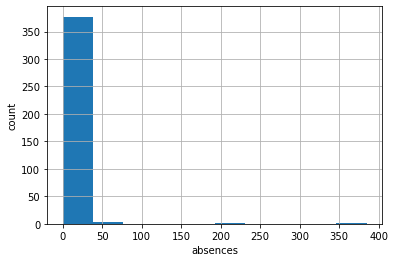

Процент пропусков: 3.04%



In [35]:
# Расмотрим столбец 'absences'
first_look('absences')

In [36]:
stud.absences.unique()

array([  6.,   4.,  10.,   2.,   0.,  16.,  nan,  14.,   7.,   8.,  25.,
        12.,  54.,  18.,  26.,  20.,  56.,  24.,  28.,   5.,  13.,  15.,
        22.,   3., 385.,  21.,   1.,  75.,  30.,  19.,   9.,  11.,  38.,
        40.,  23.,  17., 212.])

Столбец 'absences' содержит числовые величины. Означает количество пропущенных занятий. Видно, что тут 2 вброса которые нужно заменить на моду 

In [37]:
# Устраняем выбросы которые больше границы расбросов:
stud.absences = np.where(stud.absences > stud.absences.quantile(
    0.75) + 1.5*(stud.absences.quantile(0.75) - stud.absences.quantile(0.25)), stud.absences.mode(), stud.absences)

Столбец score
Распределение признака:


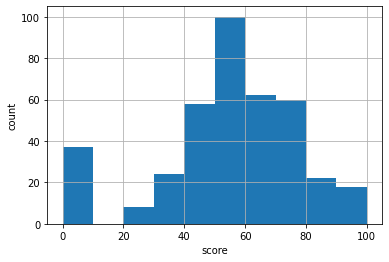

Процент пропусков: 1.52%



In [38]:
# Расмотрим столбец 'score'
first_look('score')

Столбец 'score' содержит числовые величины. Отображает баллы по госэкзамену по математике. Скорее всего 0 баллов означает опоздание, либо списывание учеником.

In [39]:
stud.score.value_counts().head(3)

50.0    54
55.0    46
0.0     37
Name: score, dtype: int64

37 учеников - это 9% от всего количества. Надо принять во внимание, что на данном этапе они не будут удалятся с датафрейма, во избежания потери большого количества данных. Но позже можно применить такие действия для прогона модели с stud.score >= 20

# 3. Итоги анализа данных: выбросы и пропуски

Выбросы найдены в 3х столбцах 'Fedu', 'famrel', 'absences' и были именены в процессе первичной обработки каждого столбца.

Итак, мы найдем столбцы, которые имеют пустые значения nan. Самая большая доля пропусков у столбцов 'Pstatus' - 11.4% и 'paid' - 10.1%. Пока это в пределах допустимого так как эти строки содержат только бинарные значения и имеют низкую важность для модели, но имеем ввиду это перспективу (возможно имеет смысл заменить nan на mode())

In [40]:
# Доля пропусков в столбцах в %:
round(stud.isna().sum()/395*100, 1).nlargest(10)

Pstatus       11.4
paid          10.1
famsup         9.9
Fjob           9.1
internet       8.6
guardian       7.8
romantic       7.8
traveltime     7.1
famsize        6.8
famrel         6.8
dtype: float64

Обозначим не коррелирующие переменные: school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardian, schoolsup, famsup, paid, activities, nursery , higher, internet, romantic   

# 4. Кореляция

In [41]:
stud.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.161704,-0.157416,0.081508,-0.015556,0.228047,0.063431,0.029023,0.135107,-0.065946,0.120734,-0.155726
Medu,-0.161704,1.000000,0.630245,-0.173515,0.078589,-0.245463,-0.020986,0.025335,0.064164,-0.045051,0.047594,0.213349
Fedu,-0.157416,0.630245,1.000000,-0.157365,0.007079,-0.271182,-0.037371,-0.019738,0.047816,0.022084,-0.037306,0.129488
traveltime,0.081508,-0.173515,-0.157365,1.000000,-0.102206,0.064699,-0.028303,-0.021937,0.037636,-0.021531,-0.047898,-0.070559
studytime,-0.015556,0.078589,0.007079,-0.102206,1.000000,-0.178992,0.028655,-0.121969,-0.051280,-0.080016,-0.067851,0.115741
failures,0.228047,-0.245463,-0.271182,0.064699,-0.178992,1.000000,0.012337,0.098382,0.120914,0.081284,0.063373,-0.344338
famrel,0.063431,-0.020986,-0.037371,-0.028303,0.028655,0.012337,1.000000,0.163765,0.069015,0.097939,-0.063186,0.051106
freetime,0.029023,0.025335,-0.019738,-0.021937,-0.121969,0.098382,0.163765,1.000000,0.296437,0.061575,0.112280,0.019026
goout,0.135107,0.064164,0.047816,0.037636,-0.051280,0.120914,0.069015,0.296437,1.000000,-0.015608,0.107577,-0.129685
health,-0.065946,-0.045051,0.022084,-0.021531,-0.080016,0.081284,0.097939,0.061575,-0.015608,1.000000,-0.002561,-0.070460


In [42]:
# Увеличим дефолтный размер графиков
rcParams['figure.figsize'] = 15, 5

<AxesSubplot:>

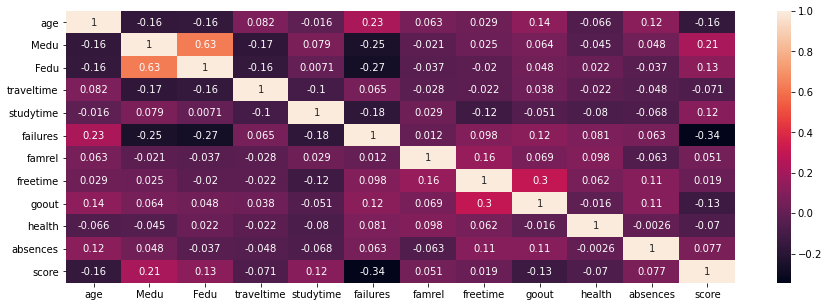

In [43]:
# Так как таблица корреляций трудно читаема, попробуем через график Heatmap
sns.heatmap(stud.corr(), annot=True)

In [44]:
# Оставим столбцы которые имеют x>=0.1 корелляции с 'score'
stud_for_model = stud.loc[:, ['Medu', 'Fedu', 'studytime']]

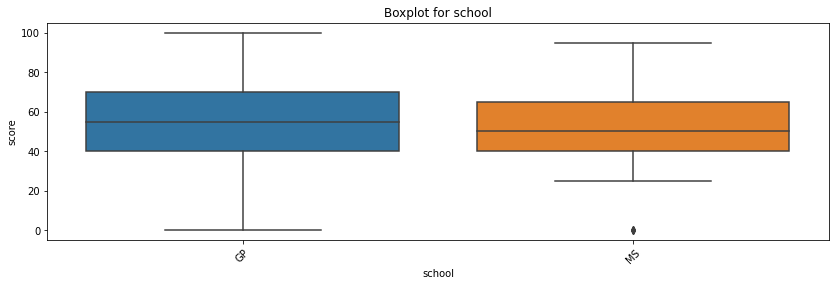

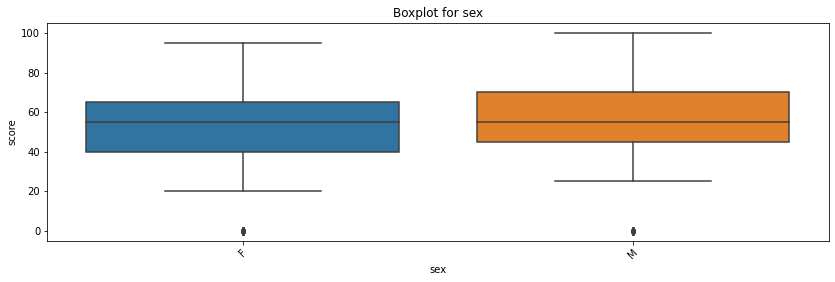

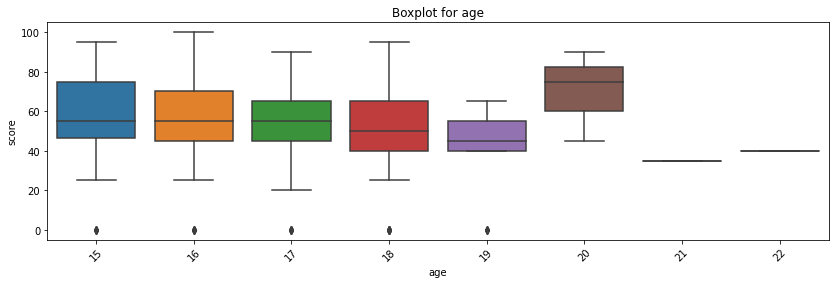

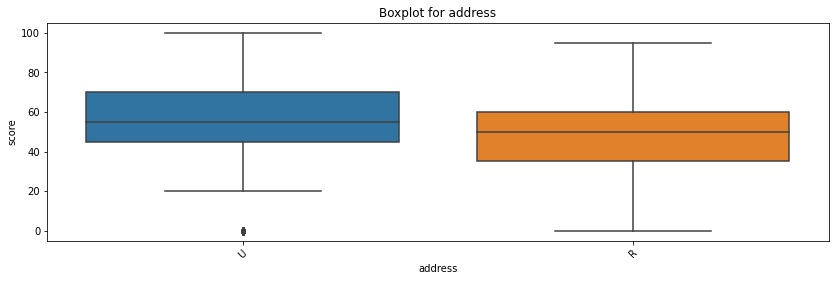

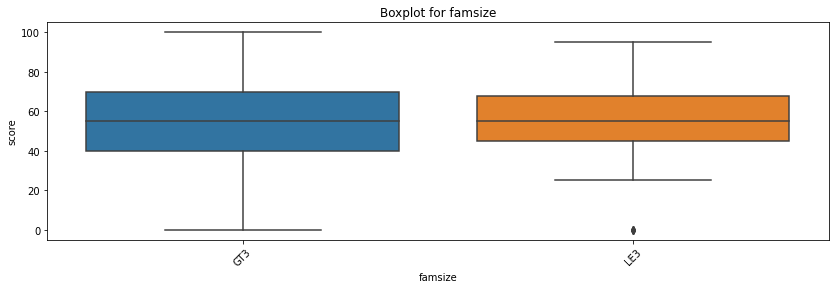

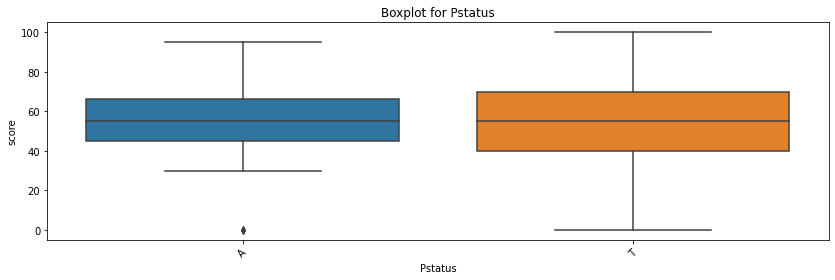

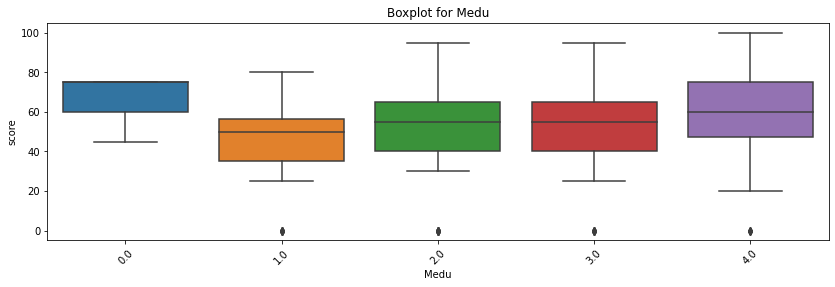

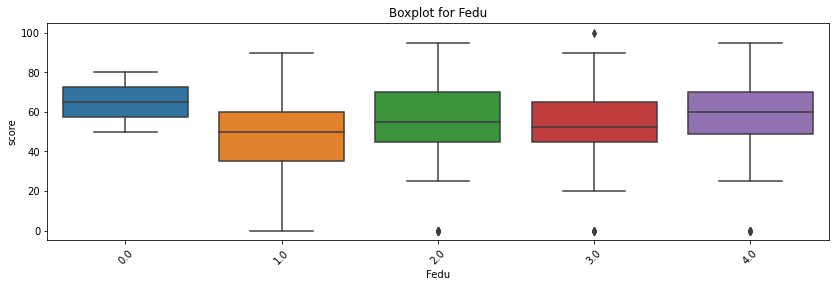

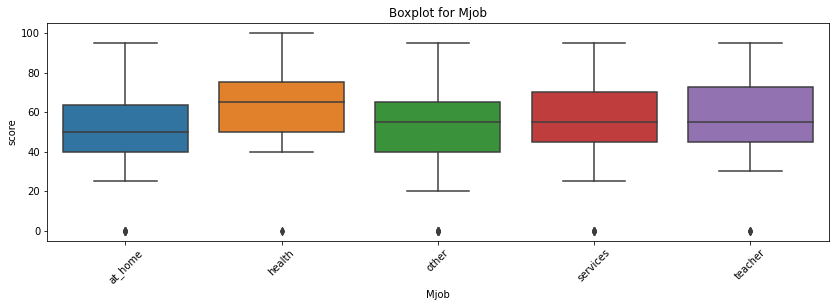

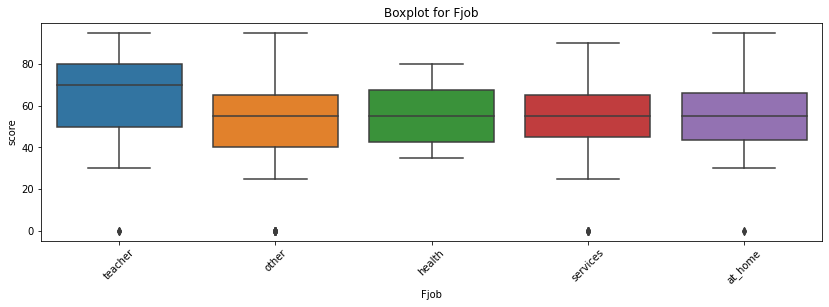

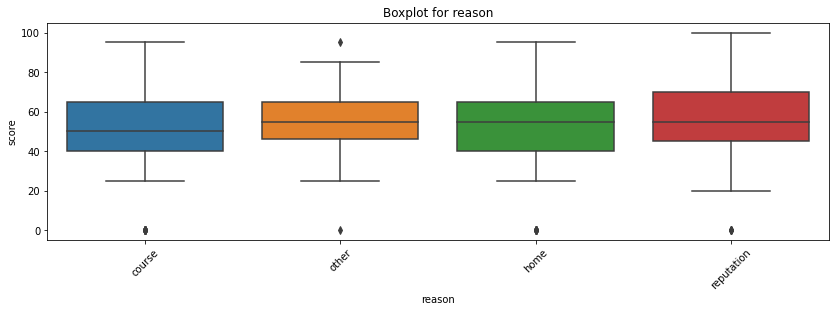

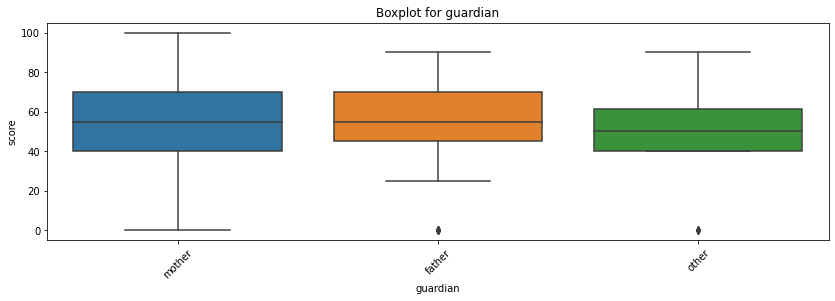

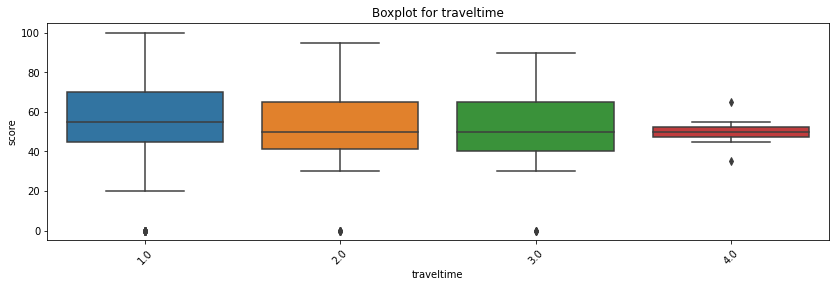

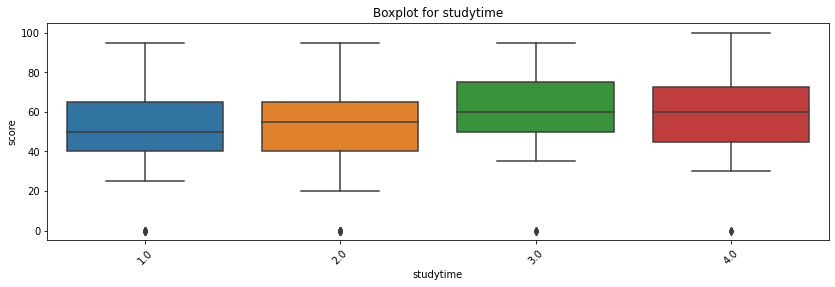

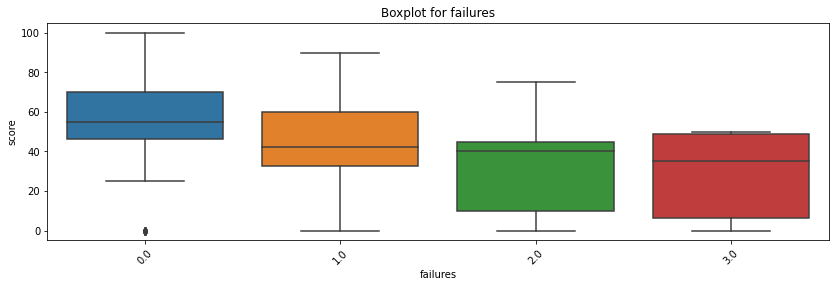

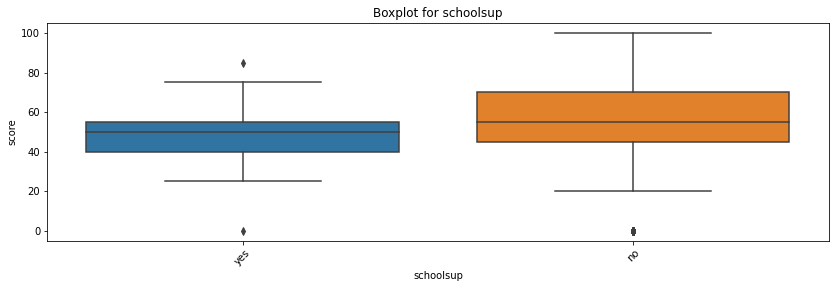

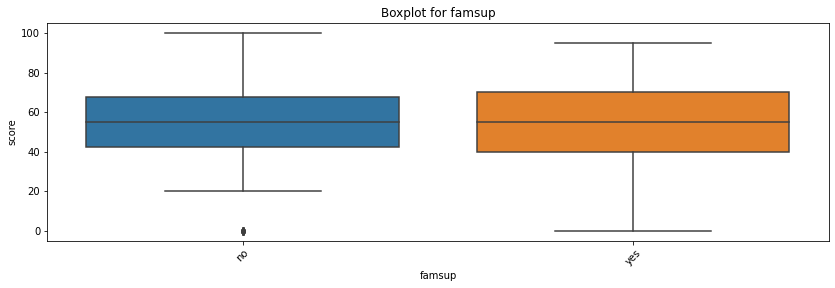

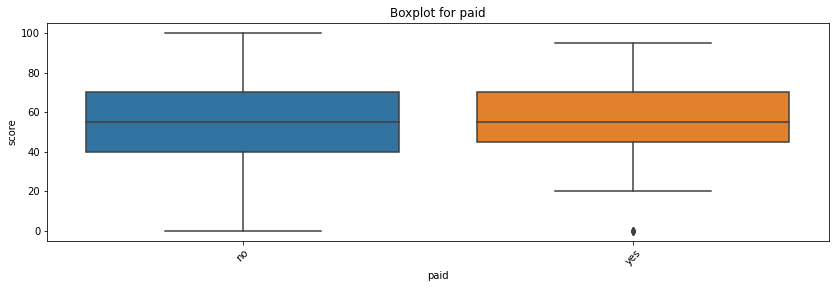

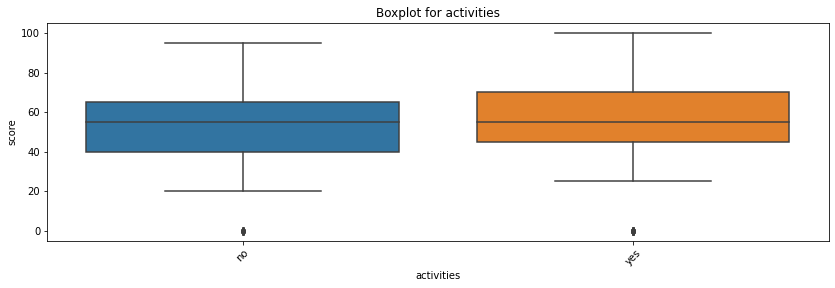

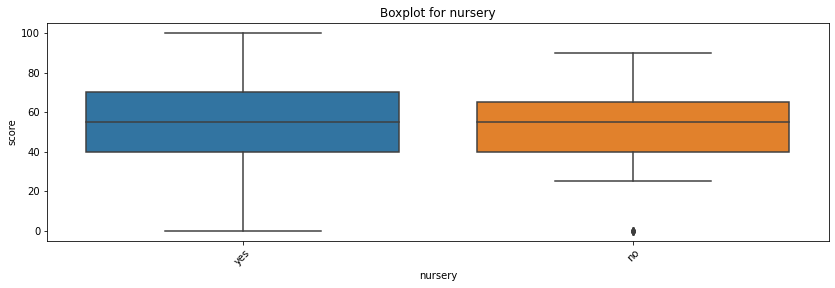

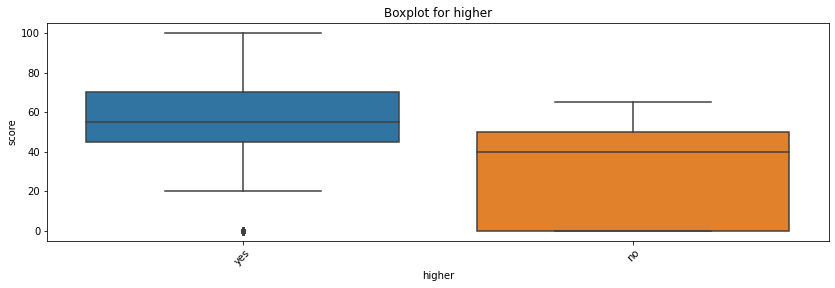

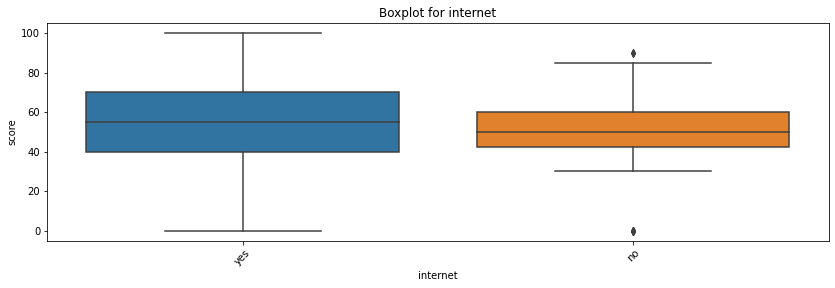

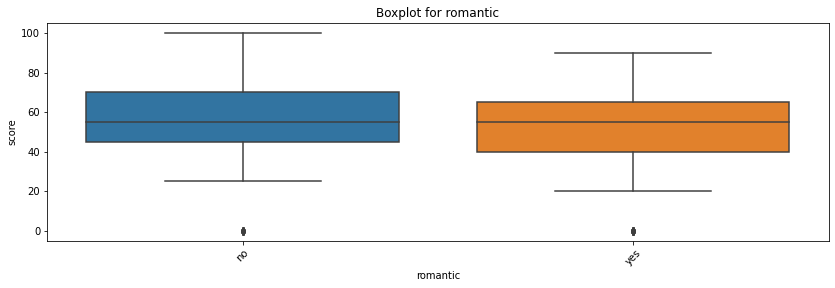

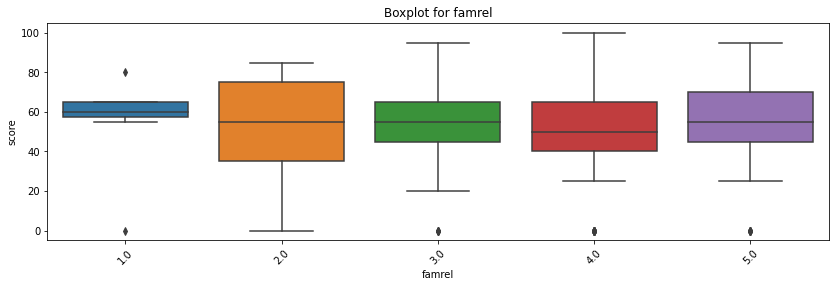

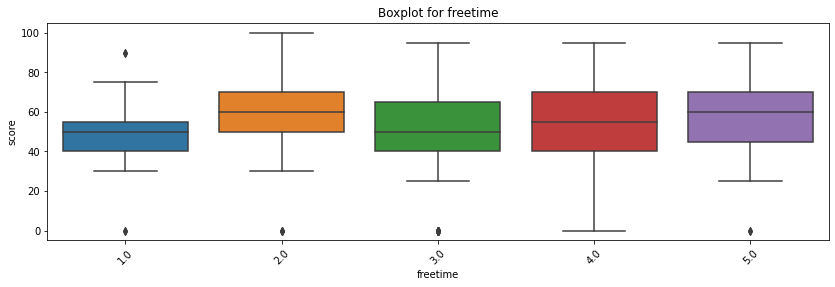

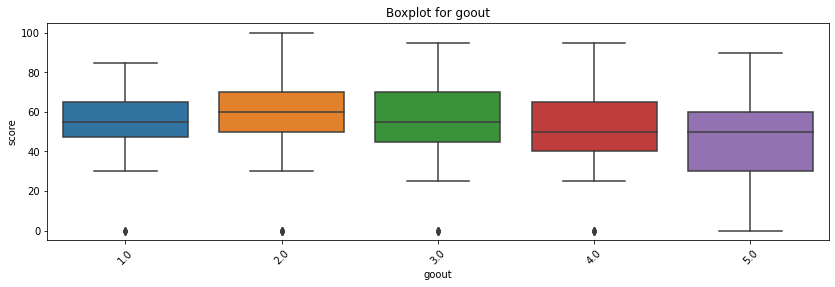

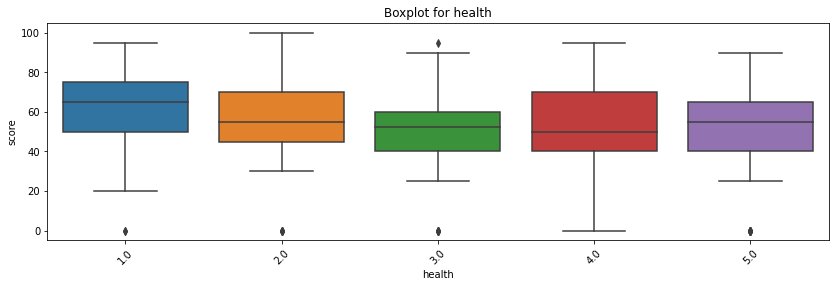

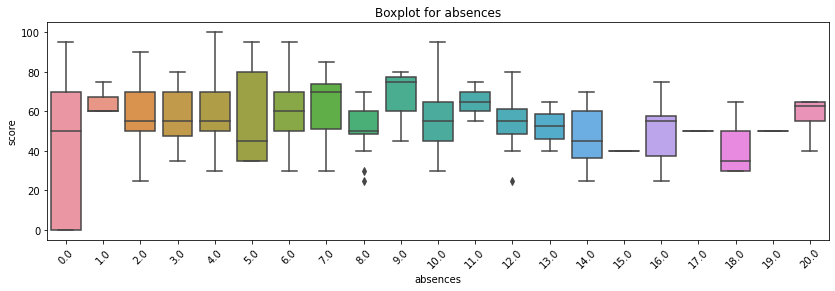

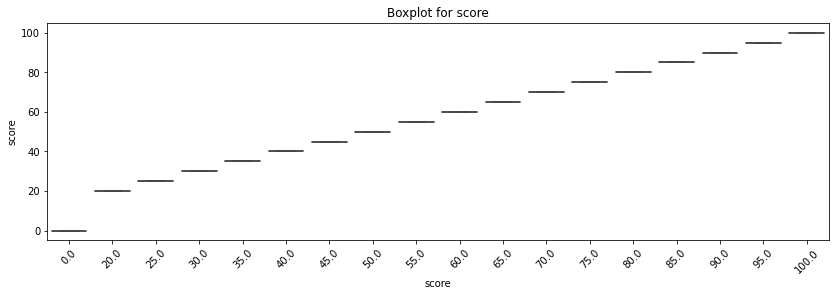

In [45]:
# Строим Boxplot графики с помощью функции 'get_boxplot'
for col in stud:
    get_boxplot(col)

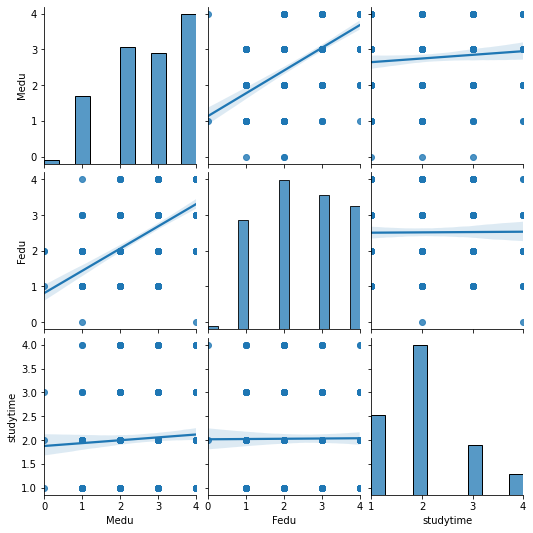

In [46]:
# Построим графики зависимости переменных через 'pairplot'
sns.pairplot(stud_for_model, kind='reg')

In [47]:
stud_for_model

,Medu,Fedu,studytime
0,4.0,4.0,2.0
1,1.0,1.0,2.0
2,1.0,1.0,2.0
3,4.0,2.0,3.0
4,3.0,3.0,2.0
...,...,...,...
390,2.0,2.0,2.0
391,3.0,1.0,1.0
392,1.0,1.0,1.0
393,3.0,2.0,1.0


# 5. Выводы:

В результате EDA для анализа влияния данных об учениках на оценку экзамена были получены следующие выводы:

1. Важные переменные, которые, возможно, окзывают влияние на успеваемость - 'Medu', 'Fedu', 'studytime'. Оставим их в датасете stud_for_model для дальнейшего построения модели. 

2. Удалили столбец 'studytime, granular' так как о нем нет информации, что означают эти данные.

3. В данных достаточно много пустых значений, и большая часть в бинарных строковых стобцах 'Pstatus', 'paid', 'famsup', которые имеют низкую важность для модели.

4. Выбросы найдены только в столбцах 'Fedu', 'famrel', 'absences', что позволяет сделать вывод о том, что данные достаточно чистые.

5. Замечено, что средняя оценка в среднем больше у учеников, отец которых является учителем (Fjob = teacher)


6. Те, кто принимает участие в экзамене впервые, чаще всего имеют в среднем выше баллы тем другие (failures = 0)

7. Средние оценки выше у тех, кто стремится получить высшее обраование (higher = yes)


8. Ученики 20 лет чаще всего имеют выше средний бал чем млашие ученики (age = 20). Но данные только за 3 ученика, нужно больше данных чтобы подтвердить эту гипотезу